Estado inicial del almacén:
Cell (0,1) has 2 boxes
Cell (0,12) has 1 boxes
Cell (0,17) has 1 boxes
Cell (1,0) has 3 boxes
Cell (1,3) has 3 boxes
Cell (1,5) has 1 boxes
Cell (1,12) has 1 boxes
Cell (1,13) has 1 boxes
Cell (2,0) has 2 boxes
Cell (2,5) has 3 boxes
Cell (2,9) has 1 boxes
Cell (2,14) has 1 boxes
Cell (2,17) has 1 boxes
Cell (3,12) has 2 boxes
Cell (3,14) has 2 boxes
Cell (3,15) has 3 boxes
Cell (4,2) has 2 boxes
Cell (4,6) has 2 boxes
Cell (4,7) has 1 boxes
Cell (4,11) has 2 boxes
Cell (4,14) has 2 boxes
Cell (4,16) has 2 boxes
Cell (4,17) has 3 boxes
Cell (5,0) has 1 boxes
Cell (5,13) has 1 boxes
Cell (5,17) has 3 boxes
Cell (6,3) has 2 boxes
Cell (6,7) has 1 boxes
Cell (6,8) has 2 boxes
Cell (6,13) has 3 boxes
Cell (6,14) has 1 boxes
Cell (6,19) has 3 boxes
Cell (7,3) has 2 boxes
Cell (7,5) has 3 boxes
Cell (7,12) has 2 boxes
Cell (7,13) has 3 boxes
Cell (7,15) has 3 boxes
Cell (7,17) has 2 boxes
Cell (8,6) has 1 boxes
Cell (8,7) has 3 boxes
Cell (8,14) has 3 boxes
Cell (

/var/folders/1b/8nqnwbjd0kzffk1mtbskrgbm0000gn/T/ipykernel_6778/729361116.py:153: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.Blues, vmin=0, vmax=5)


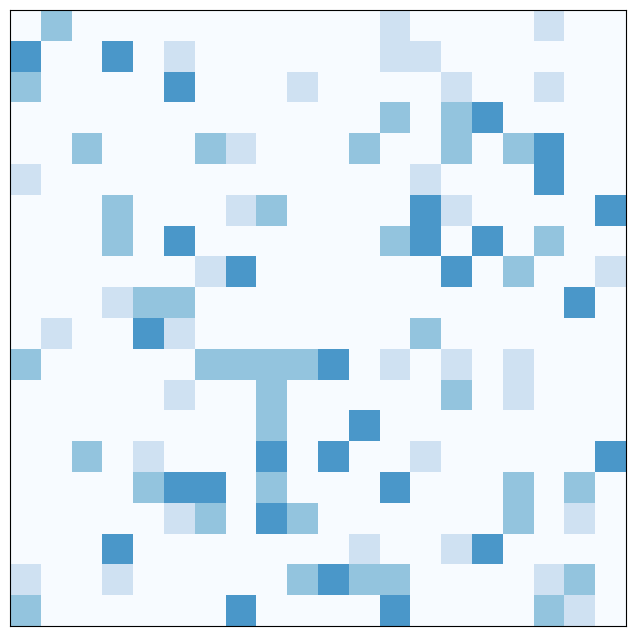

In [16]:
# Importar las clases necesarias de Mesa y otras bibliotecas
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

# Establecer la semilla para la generación de números aleatorios
random.seed(67890)
np.random.seed(67890)

# Definir la clase de los robots
class Robot(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.carrying = 0
    
    def step(self):
        self.move()
        self.pick_or_drop_box()
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    def pick_or_drop_box(self):
        x, y = self.pos
        cell_content = self.model.grid.get_cell_list_contents([self.pos])
        boxes_in_cell = [obj for obj in cell_content if isinstance(obj, Box)]
        
        if self.carrying == 0 and len(boxes_in_cell) > 0:
            # Recoger una caja
            self.carrying += 1
            self.model.grid.remove_agent(boxes_in_cell[0])
            print(f"Robot {self.unique_id} recogió una caja en ({x},{y})")
        elif self.carrying > 0 and len(boxes_in_cell) < 5:
            # Dejar una caja si hay menos de 5 en la celda
            self.carrying -= 1
            new_box = Box(self.model.next_id(), self.model)
            self.model.grid.place_agent(new_box, self.pos)
            print(f"Robot {self.unique_id} dejó una caja en ({x},{y})")

# Definir la clase de las cajas
class Box(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

# Definir la clase del modelo del almacén
class WarehouseModel(Model):
    def __init__(self, width, height, num_robots, num_boxes):
        super().__init__()  # Inicializar la clase base Model
        self.current_id = 0  # Inicializar el current_id
        self.num_agents = num_robots
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": self.get_grid})
        self.running = True  # Inicializar running
        
        # Crear robots
        for i in range(self.num_agents):
            robot = Robot(self.next_id(), self)
            x, y = self.get_empty_position()
            self.grid.place_agent(robot, (x, y))
            self.schedule.add(robot)
        
        # Crear cajas
        boxes_to_place = num_boxes
        while boxes_to_place > 0:
            group_size = min(random.randint(1, 3), boxes_to_place)
            x, y = self.get_empty_position()
            for _ in range(group_size):
                box = Box(self.next_id(), self)
                self.grid.place_agent(box, (x, y))
            boxes_to_place -= group_size
    
    def get_empty_position(self):
        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                return (x, y)
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if self.all_boxes_stacked():
            self.running = False
    
    def all_boxes_stacked(self):
        for (content, (x, y)) in self.grid.coord_iter():
            boxes_in_cell = [obj for obj in content if isinstance(obj, Box)]
            if len(boxes_in_cell) not in (0, 5):
                return False
        return True
    
    def get_grid(self):
        grid = np.zeros((self.grid.width, self.grid.height))
        for (content, (x, y)) in self.grid.coord_iter():
            grid[x][y] = len([obj for obj in content if isinstance(obj, Box)])
        return grid

    def print_grid(self):
        for (content, (x, y)) in self.grid.coord_iter():
            boxes_in_cell = len([obj for obj in content if isinstance(obj, Box)])
            if boxes_in_cell > 0:
                print(f"Cell ({x},{y}) has {boxes_in_cell} boxes")

# Parámetros de la simulación
width = 20
height = 20
num_robots = 5
num_boxes = 200
max_steps = 500

# Inicializar el modelo
model = WarehouseModel(width, height, num_robots, num_boxes)

# Imprimir el estado inicial
print("Estado inicial del almacén:")
model.print_grid()

# Ejecutar la simulación
for i in range(max_steps):
    model.step()
    if not model.running:
        break

# Obtener los datos de la simulación
all_grid = model.datacollector.get_model_vars_dataframe()

# Imprimir el estado final
print("\nEstado final del almacén:")
model.print_grid()

# Verificar si todas las pilas tienen exactamente 5 cajas
if model.all_boxes_stacked():
    print("\nTodas las cajas están correctamente apiladas en pilas de 5 cajas.")
else:
    print("\nNo todas las cajas están apiladas correctamente.")

# Visualizar la simulación
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.Blues, vmin=0, vmax=5)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))
plt.show()
